In [1]:
%load_ext autoreload
%autoreload 2
import comethylation, get_data, analysis, utils

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

### REad in PANCAN

In [4]:
out_dir = "./output_081722"
dependency_f_dir = "./dependency_files"
data_dir = "./data"

In [6]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
                                                                                                                  out_dir,
                                                                                                                  os.path.join(data_dir, "processed_methylation"),
                                                                                                                  os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
                                                                                                                  os.path.join(data_dir, "PANCAN_meta.tsv"))


Got mutations and metadata, reading methylation
Converting Dask df to pandas df
Got methylation, transposing
Done


## Read in data

In [4]:
# set args
illum_cpg_locs_fn = "./dependency_files/illumina_cpg_450k_locations.csv"
out_dir = "./output_081322"
dependency_f_dir = "./dependency_files"
data_dirs = glob.glob( os.path.join("./data", "tcga*data"))

In [ ]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(illum_cpg_locs_fn, out_dir, data_dirs)

## Do mutation analyses

/cellar/users/zkoch/methylation_and_mutation/analysis.py:73: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  statistic, p_val = stats.ranksums(ct_mutation_in_measured_cpg_df['methyl_fraction'].to_numpy(), ct_mutation_in_measured_cpg_df['avg_methyl_frac'].to_numpy(), alternative='less')
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


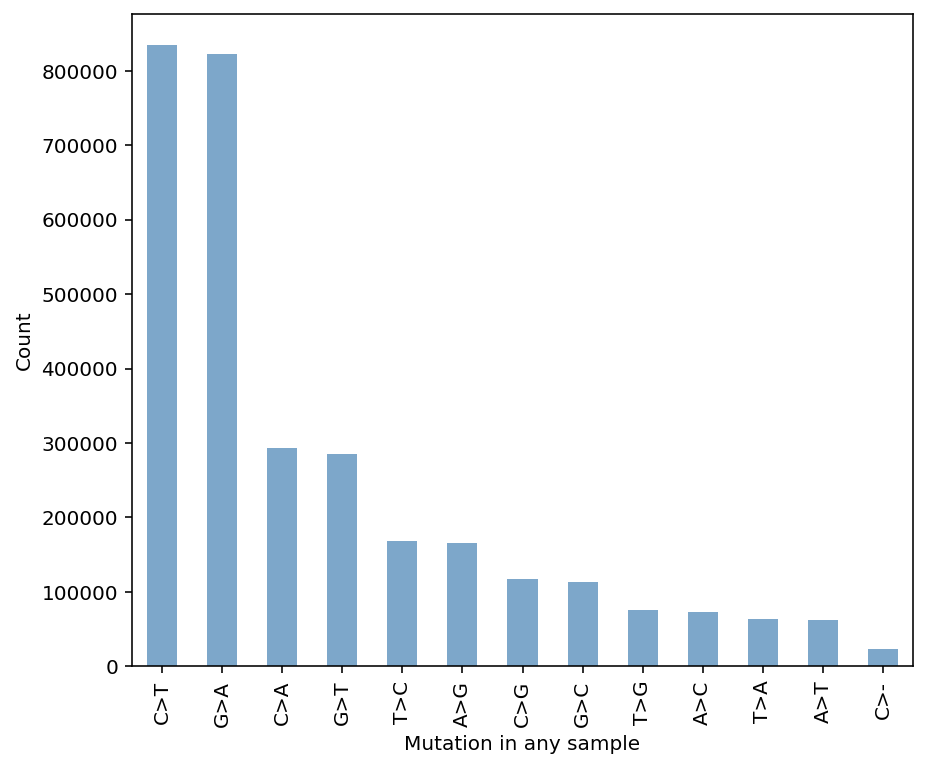

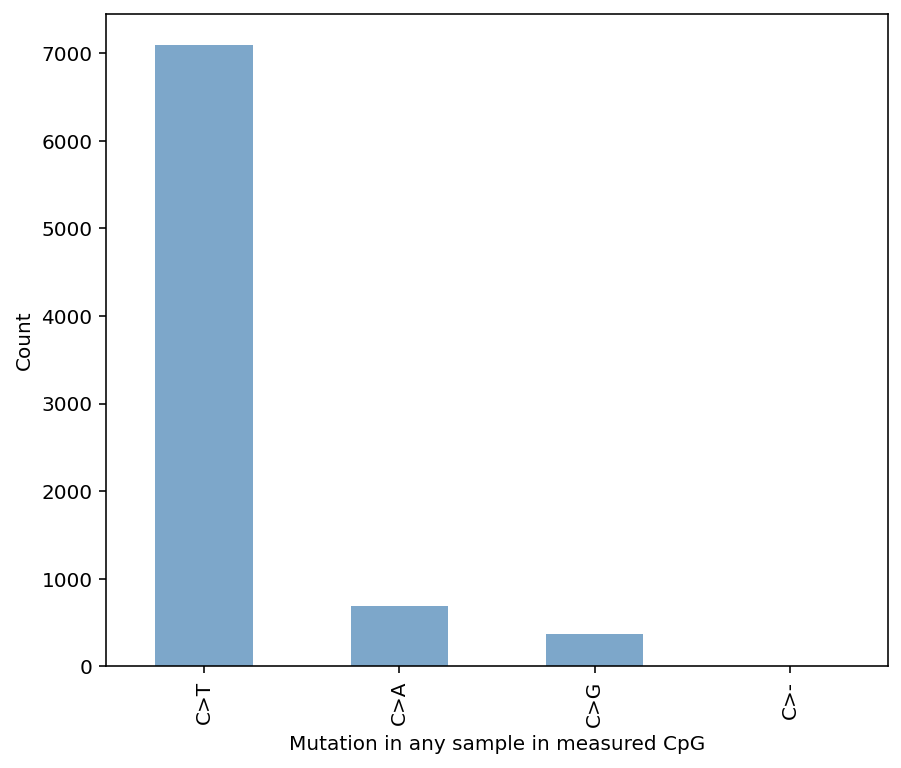

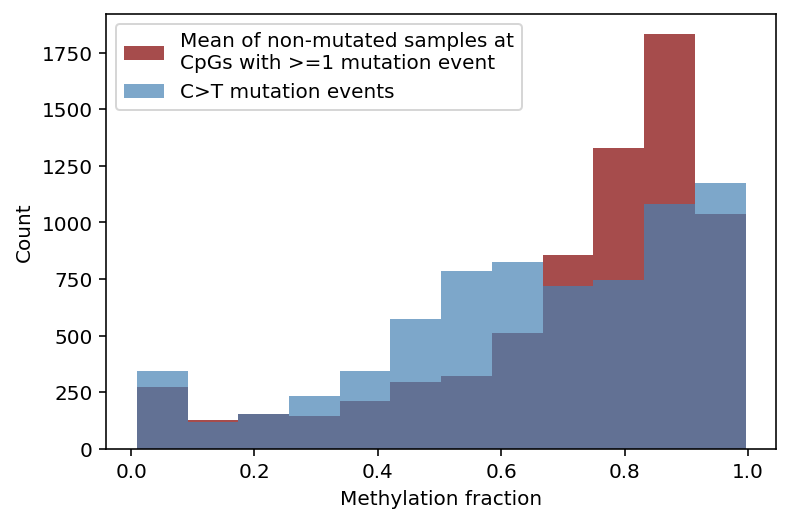

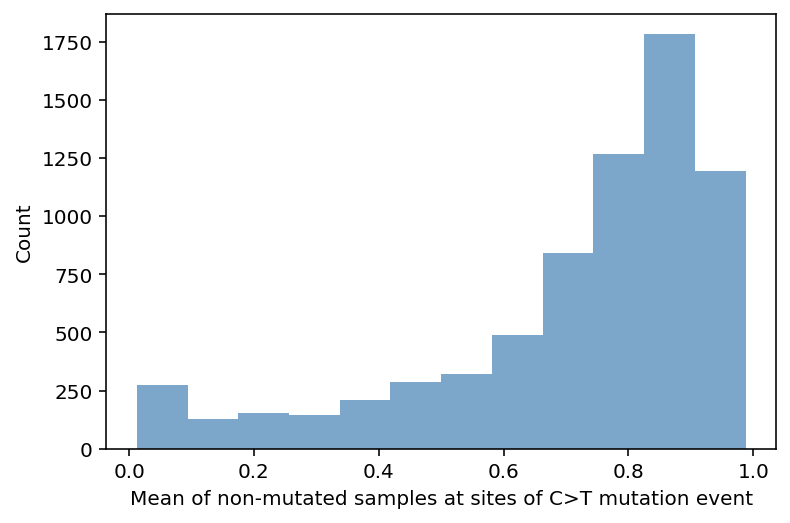

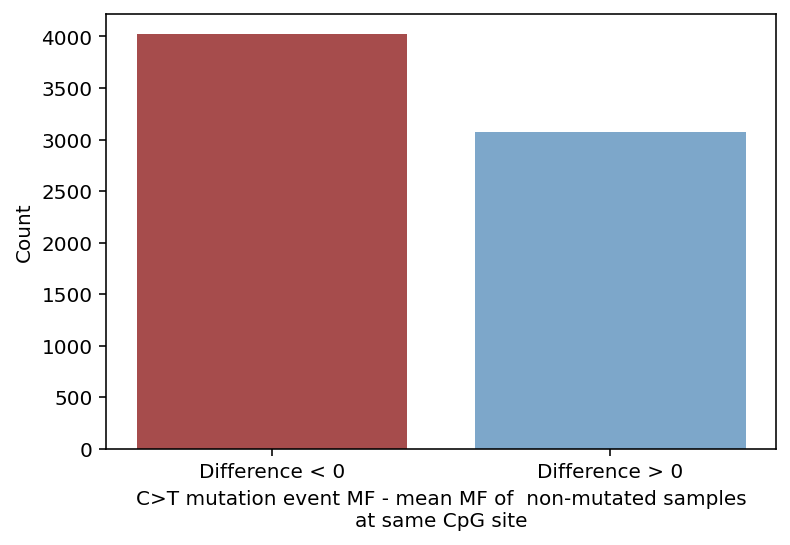

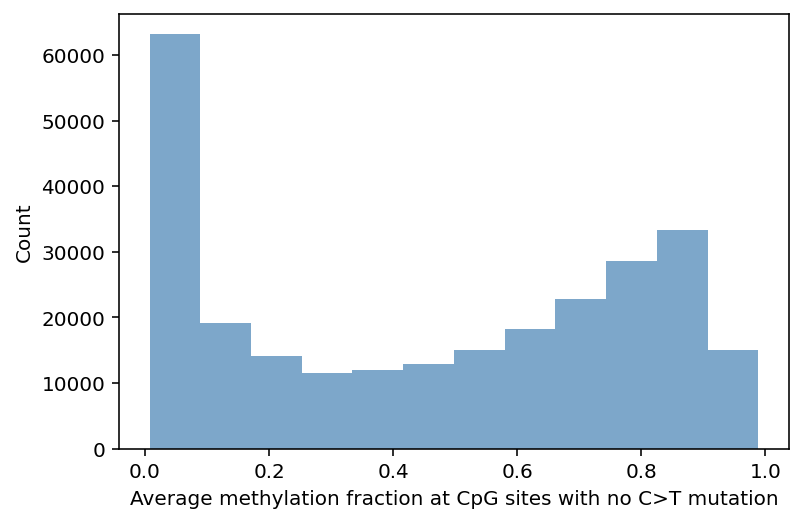

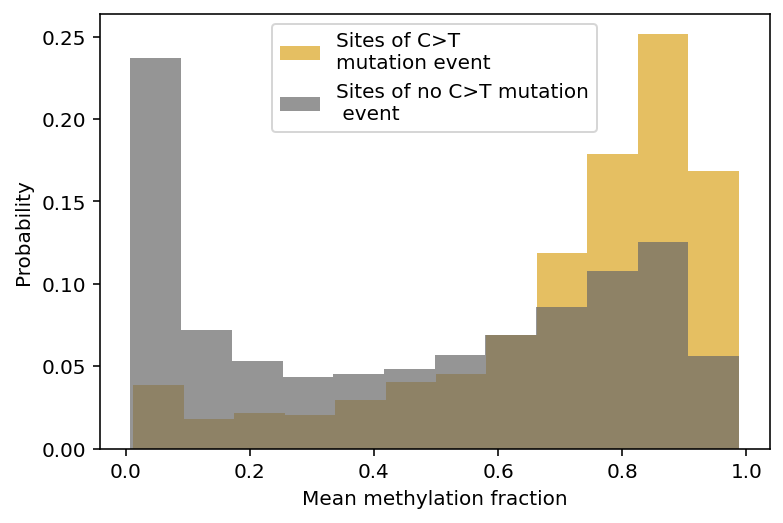

In [10]:
mut_in_measured_cpg_df, ct_mut_in_measured_cpg_df, ct_mut_in_measured_cpg_w_methyl_df = analysis.main(illumina_cpg_locs_df, out_dir, all_mut_df, all_methyl_df_t, all_meta_df, dataset_names_list) 

In [17]:
# save ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df.to_parquet(os.path.join(dependency_f_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

## Do comethylation analysis

### comethylation without absolute value

In [18]:
# read correlations between all CpG sites on chr1 in
chrom_one_corr = pd.read_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))

In [13]:
# read in ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df = pd.read_parquet(os.path.join(dependency_f_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

In [ ]:
# switch from corr to chrom_one_corr

In [19]:
# add ages to ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_age_df, all_methyl_age_df_t = comethylation.add_ages_to_methylation(ct_mut_in_measured_cpg_w_methyl_df, all_meta_df, all_methyl_df_t)

In [26]:
# get num_mut_sites sites with largeset MF differences that are on chrom 1 to use as sites in co-methylation analysis
num_mut_sites = 100
most_negative_diffs = ct_mut_in_measured_cpg_w_methyl_age_df[ct_mut_in_measured_cpg_w_methyl_age_df['#id'].isin(chrom_one_corr.columns)].sort_values(by='difference').iloc[:num_mut_sites]
max_diff_corr_df = chrom_one_corr[most_negative_diffs['#id']]

In [15]:
# Run co-methylation, takes a while
# calculate mutation impact varying percentile of linked CpG sites
result_dfs = comethylation.mutation_eff_varying_linkage(ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, all_methyl_age_df_t,illumina_cpg_locs_df, num_linked_sites = 100, age_bin_size = 10)

0.99
0.8811111111111111
0.7722222222222221
0.6633333333333333
0.5544444444444444
0.44555555555555554
0.33666666666666667
0.22777777777777777
0.11888888888888888
0.01


In [17]:
# write out result_dfs
utils.write_out_result_dfs('/cellar/users/zkoch/methylation_and_mutation/output_080422/', '100_sites_varying_percentile_chr1', result_dfs)

In [22]:
# read in result_dfs
result_dfs = utils.read_in_result_dfs('/cellar/users/zkoch/methylation_and_mutation/output_080422/_100_sites_varying_percentile_chr1')

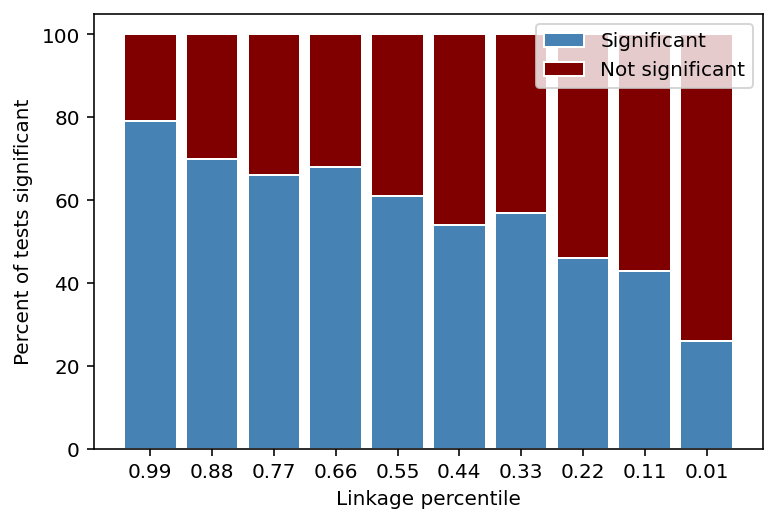

In [18]:
# updated to be MavgErr
comethylation.plot_sig_bars(result_dfs)

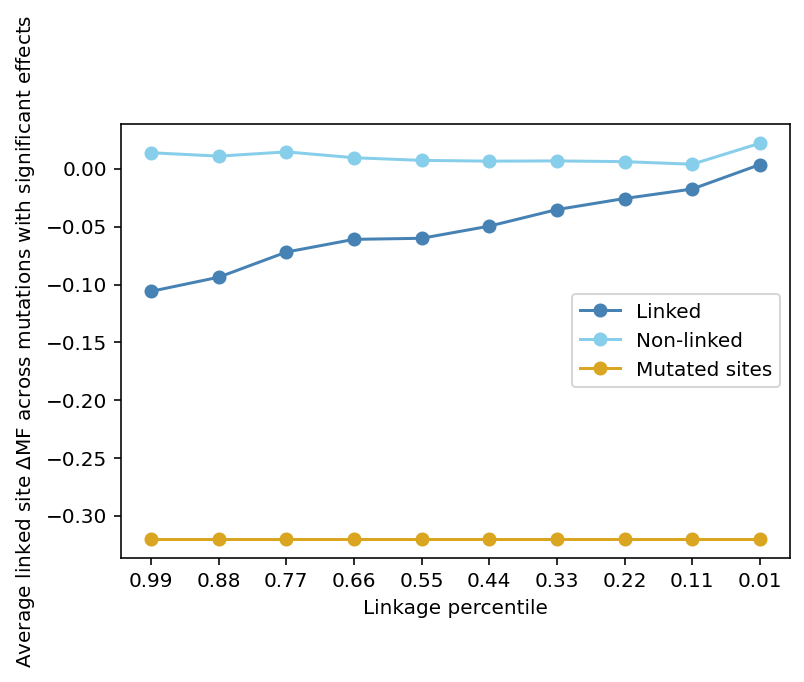

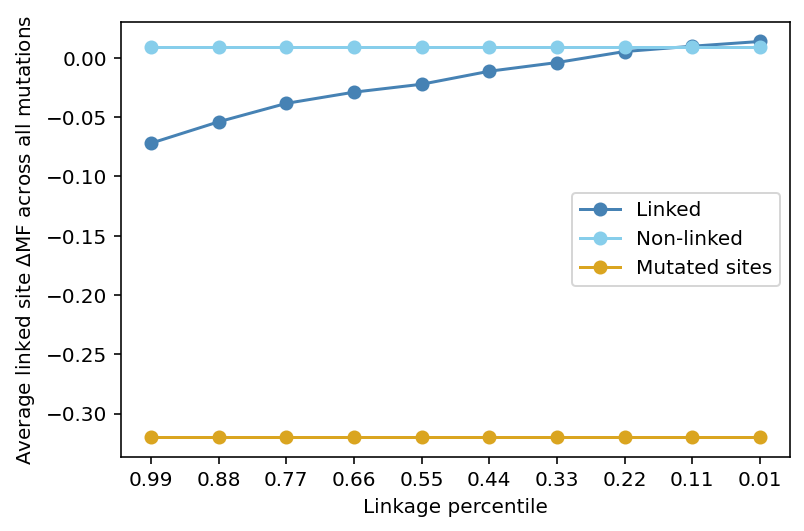

In [24]:
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, sig_only=True)
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, sig_only=False)

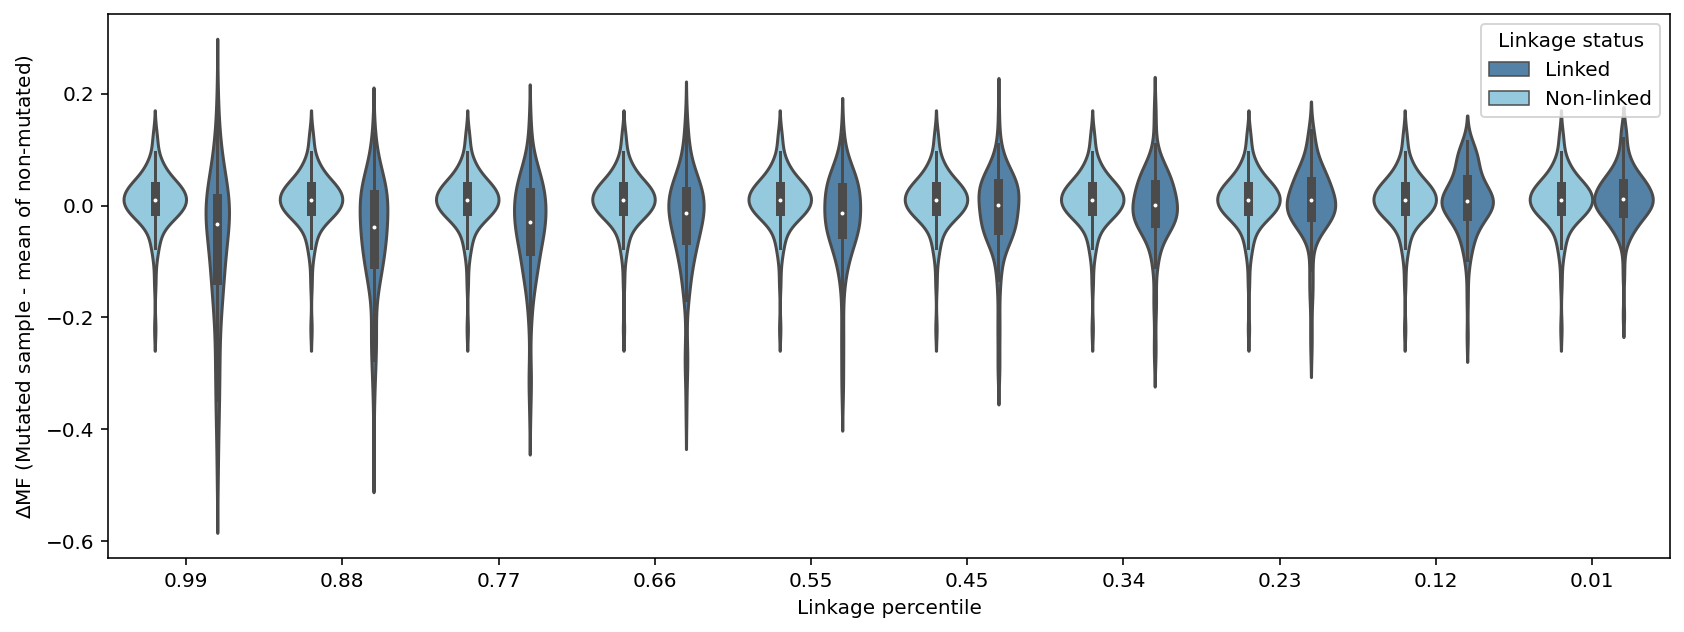

In [ ]:
# this is all sites, not just sig
comethylation.plot_eff_violin(result_dfs)

# Miscellaneous code to save

## Get all correlations chrom 1

In [9]:
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]

In [ ]:
chrom_one_corr = chr_methyl_df.T.corr()
chrom_one_corr.to_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))

In [11]:
# read back in 
chrom_one_corr = pd.read_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))

## EWAS chr1

In [27]:
# only keep sites on chr 1
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]
# only keep ages that match to columns of chr_methyl_df
all_meta_df = all_meta_df.loc[all_meta_df.index.isin(chr_methyl_df.columns)]
# only keep columns that have ages
chr_methyl_df = chr_methyl_df[chr_methyl_df.columns[chr_methyl_df.columns.isin(all_meta_df.index)]]
# put samples in same order as methylation
all_meta_df = all_meta_df.loc[chr_methyl_df.columns]

In [ ]:
# do EWAS calculation
ewas_df = utils.EWAS(X = chr_methyl_df, y = all_meta_df['age_at_index'], out_fn = out_fn)
ewas_df.index = chr_methyl_df.index

In [21]:
# read in if already calculated
ewas_df = pd.read_parquet(os.path.join(dependency_f_dir, "all_chr1_EWAS_results.parquet"))
ewas_df.index = chr_methyl_df.index

In [30]:
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')

# Associating # mutations with % methylation explained, not done

In [29]:
# read in ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df = pd.read_parquet(os.path.join(out_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))
# correlations of each CpG on chr1 with age
ewas_df = pd.read_parquet(os.path.join(out_dir, "all_chr1_EWAS_results.parquet"))
ewas_df.index = chr_methyl_df.index
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')
# co-methylation for all CpGs on chr1
chrom_one_corr = pd.read_parquet(os.path.join(out_dir, "all_corrs_chrom1.parquet"))
# comethylation result dfs
result_dfs = utils.read_in_result_dfs(os.path.join(out_dir, '_100_sites_varying_percentile_chr1'))

## Count mutations nearby 1000 negatively associated CpGs

In [33]:
# we only care about mutations in samples with some methylation (doesn't have to be 
all_mut_w_methyl_df = all_mut_df[all_mut_df['sample'].isin(all_methyl_df.columns.to_list())]
cpg_sample_distance_mut_count_df = comethylation.count_nearby_mutations(ewas_df.iloc[:1000],
                                                                        all_mut_w_methyl_df,
                                                                        illumina_cpg_locs_df,
                                                                        all_methyl_df,
                                                                        10000)

In [ ]:
cpg_sample_distance_mut_count_df.to_parquet(os.path.join(out_dir, "cpg_sample_mut_count_negative_1000.parquet"))

In [32]:
# read in output 
cpg_sample_distance_mut_count_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_mut_count_negative_1000.parquet"))

## Count LINKED mutations for 1000 negatively associated CpGs

In [ ]:
# instead of counting nearby mutations, count mutations that are in linked CpG sites
cpg_sample_linked_mut_count_df = comethylation.count_linked_mutations(cpgs_to_count_df = ewas_df.iloc[:1000],
                       all_mut_w_methyl_df = all_mut_w_methyl_df,
                       illumina_cpg_locs_df = illumina_cpg_locs_df,
                       all_methyl_df = all_methyl_df, 
                       corr_df = chrom_one_corr, 
                       num=100,
                       percentile_cutoff=.9999)

In [34]:
# read in 1000 sites, 100 linked sites, 100bp each
cpg_sample_ten_linked_mut_count_df = pd.read_parquet(os.path.join(out_dir,"cpg_sample_linked_mut_count_1000_tenLinkedSites_1kbp_df.parquet"))

In [35]:
cpg_sample_thou_linked_mut_count_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_1000_100LinkedSites_100bp_df.parquet"))

## Count mutations all ways for 1000 least age-associated sites

In [40]:
# get least age-associated, lowest 1000 absoluteval
ewas_by_abs = np.abs(ewas_df).sort_values(by = 'pearson_corrs')

In [76]:
# we only care about mutations in samples with some methylation (doesn't have to be 
all_mut_w_methyl_df = all_mut_df[all_mut_df['sample'].isin(all_methyl_df.columns.to_list())]
cpg_sample_distance_mut_count_lowest_df = comethylation.count_nearby_mutations(ewas_by_abs.iloc[:1000],
                                                                        all_mut_w_methyl_df,
                                                                        illumina_cpg_locs_df,
                                                                        all_methyl_df,
                                                                        max_dist=100000)

In [173]:
cpg_sample_distance_mut_count_lowest_df.to_parquet(os.path.join(out_dir, "cpg_sample_mut_count_lowest_1000.parquet"))

In [36]:
cpg_sample_distance_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_mut_count_lowest_1000.parquet"))

In [37]:
cpg_sample_ten_corr_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_lowest_1000_tenLinkedSites_1kbp_df.parquet"))

In [38]:
cpg_sample_thou_corr_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_leastAssoc_1000_100LinkedSites_100bp_df.parquet"))

## corr(# linked mutations in site i, age) for 1000 sites with strongest negative age association on chr1

In [176]:
# correlation between ages and # linked sites by DISTANCE for 1000cpgs
# keep only samples with ages and ages that have relevant sample
cpg_sample_mut_count_to_corr = cpg_sample_distance_mut_count_df.loc[cpg_sample_distance_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr = all_meta_df.loc[cpg_sample_mut_count_to_corr.index]['age_at_index']
age_mut_count_corr = cpg_sample_mut_count_to_corr.corrwith(ages_to_corr)

In [179]:
# nonlinked sites distance
cpg_sample_mut_count_lowest_to_corr = cpg_sample_distance_mut_count_lowest_df.loc[cpg_sample_distance_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr = all_meta_df.loc[cpg_sample_mut_count_lowest_to_corr.index]['age_at_index']
age_mut_count_lowest_corr = cpg_sample_mut_count_lowest_to_corr.corrwith(ages_to_corr)

In [197]:
# same thing but by 10 linked sites
cpg_sample_ten_mut_count_to_corr_link = cpg_sample_ten_linked_mut_count_df.loc[cpg_sample_ten_linked_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_mut_count_to_corr_link.index]['age_at_index']
age_mut_ten_count_corr_link = cpg_sample_ten_mut_count_to_corr_link.corrwith(ages_to_corr_link)

In [198]:
# 10 linked sites nonlinked
cpg_sample_ten_mut_count_lowest_to_corr_link = cpg_sample_ten_corr_mut_count_lowest_df.loc[cpg_sample_ten_corr_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_ten_mut_count_lowest_to_corr_link.index]['age_at_index']
age_mut_ten_count_lowest_corr_link = cpg_sample_ten_mut_count_lowest_to_corr_link.corrwith(ages_to_corr_link)

In [299]:
# 100 linked sites linked
cpg_sample_thou_mut_count_to_corr_link = cpg_sample_thou_linked_mut_count_df.loc[cpg_sample_thou_linked_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_thou_mut_count_to_corr_link.index]['age_at_index']
age_mut_thou_count_corr_link = cpg_sample_thou_mut_count_to_corr_link.corrwith(ages_to_corr_link)

In [301]:
# 10 linked sites nonlinked
cpg_sample_thou_mut_count_lowest_to_corr_link = cpg_sample_thou_corr_mut_count_lowest_df.loc[cpg_sample_thou_corr_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_thou_mut_count_lowest_to_corr_link.index]['age_at_index']
age_mut_thou_count_lowest_corr_link = cpg_sample_thou_mut_count_lowest_to_corr_link.corrwith(ages_to_corr_link)

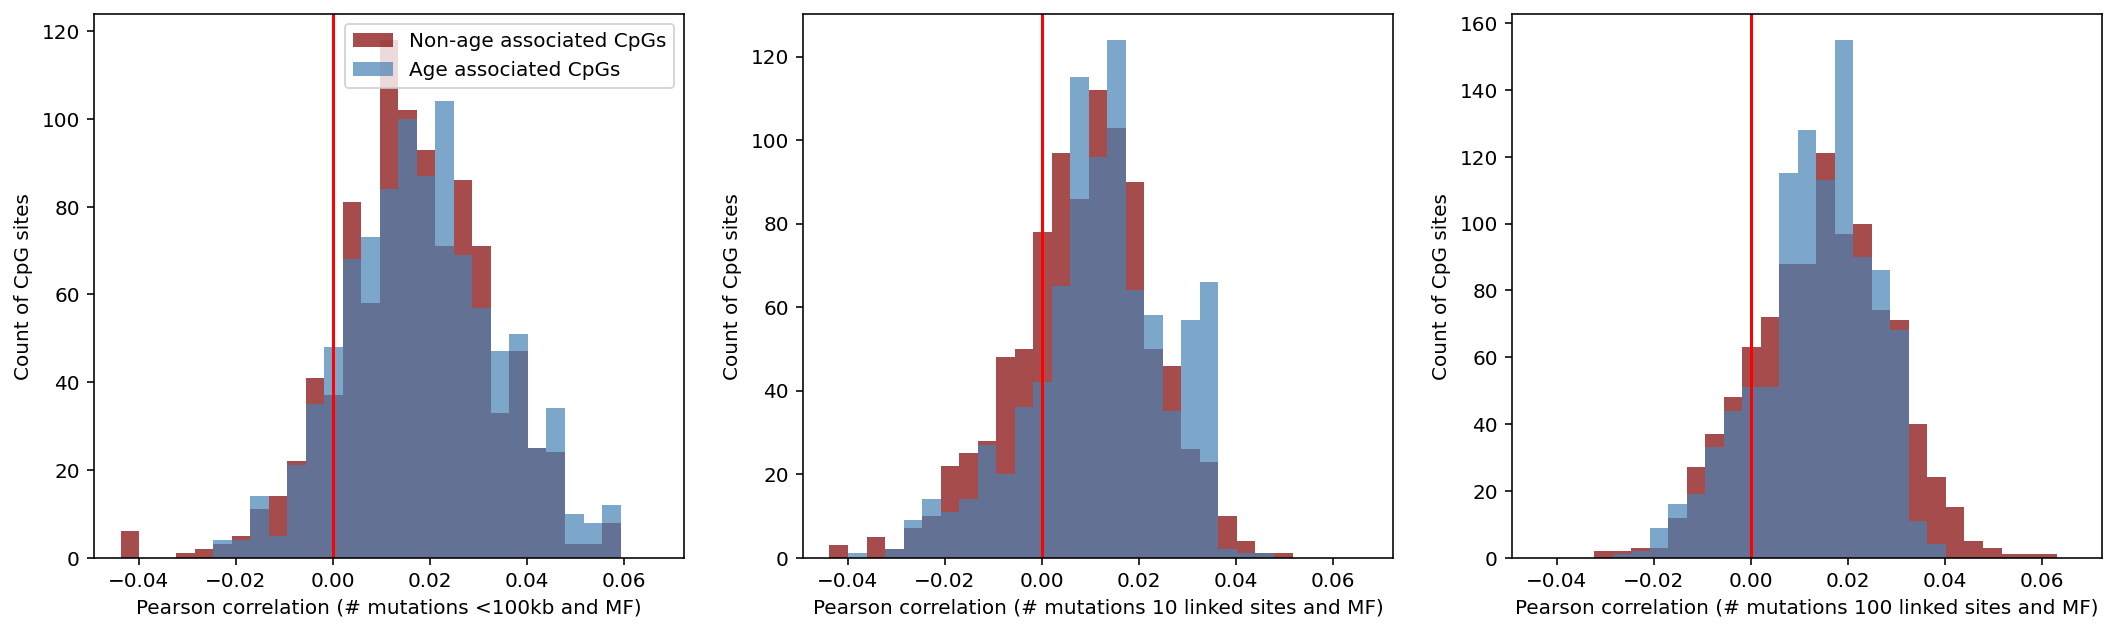

In [307]:
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex='all')

minn = min(age_mut_count_corr.min(),age_mut_count_lowest_corr.min())
maxx =max(age_mut_count_corr.max(),age_mut_count_lowest_corr.max())
age_mut_count_lowest_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30) , ax=axes[0],color='maroon',alpha=0.7,label="Non-age associated CpGs" )
age_mut_count_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[0], color='steelblue',alpha=0.7,label="Age associated CpGs")
axes[0].set_xlabel("Pearson correlation (# mutations <100kb and MF)")
axes[0].set_ylabel("Count of CpG sites")
axes[0].axvline(x=0, c='r')
axes[0].legend()

age_mut_ten_count_lowest_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1], color='maroon',alpha=0.7)
age_mut_ten_count_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1], color='steelblue',alpha=0.7)
axes[1].set_xlabel("Pearson correlation (# mutations 10 linked sites and MF)")
axes[1].set_ylabel("Count of CpG sites")
axes[1].axvline(x=0, c='r')

age_mut_thou_count_lowest_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='maroon',alpha=0.7)
age_mut_thou_count_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='steelblue',alpha=0.7)
axes[2].set_xlabel("Pearson correlation (# mutations 100 linked sites and MF)")
axes[2].set_ylabel("Count of CpG sites")
axes[2].axvline(x=0, c='r')

## corr(#linked mutations,MF)

In [41]:
# subset to CpGs most negatively asspociated with age
meth_corr = cpg_sample_distance_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_lowest_corr = cpg_sample_distance_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])

meth_corr_ten_link = cpg_sample_ten_linked_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_corr_ten_lowest_link = cpg_sample_ten_corr_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])

meth_corr_thou_link = cpg_sample_thou_linked_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_corr_thou_lowest_link = cpg_sample_thou_corr_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])


In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex='all')

minn = min(meth_corr.min(),meth_lowest_corr.min())
maxx =max(meth_corr.max(),meth_lowest_corr.max())
meth_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30) , ax=axes[0],color='maroon',alpha=0.7,label="Age associated CpGs")
meth_lowest_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[0], color='steelblue',alpha=0.7, label="Non-age associated")
axes[0].set_xlabel("Pearson correlation (# mutations <100kb and MF)")
axes[0].set_ylabel("Count of CpG sites")
axes[0].axvline(x=0, c='r')
axes[0].legend()

meth_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1],color='maroon',alpha=0.7,label="Age associated")
meth_corr_ten_lowest_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1],color='steelblue',alpha=0.7,label="Age associated")
axes[1].set_xlabel("Pearson correlation (# mutations 10 linked sites and MF)")
axes[1].set_ylabel("Count of CpG sites")
axes[1].axvline(x=0, c='r')

meth_corr_thou_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='maroon', alpha=0.7,label="Age associated")
meth_corr_thou_lowest_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2],color='steelblue', alpha=0.7,label="Age associated")
axes[2].set_xlabel("Pearson correlation (# mutations 100 linked sites and MF)")
axes[2].set_ylabel("Count of CpG sites")
axes[2].axvline(x=0, c='r')

"""
- This shows that the CpG sites which lose the most methylation with age, on average, have methylations more correlated with the # of linked 
mutations, than sites whose methylation is not correlated with age.
    - correlation with

"""

Text(0, 0.5, 'C>T Mutation event MF - Average non-mutation event MF')

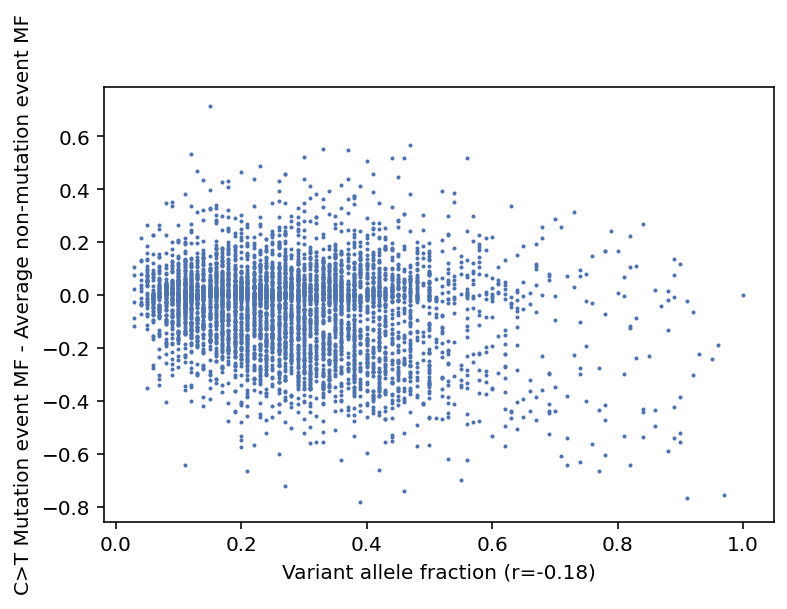

In [253]:
fig, axes = plt.subplots()
axes.scatter(ct_mut_in_measured_cpg_w_methyl_df['DNA_VAF'], ct_mut_in_measured_cpg_w_methyl_df['difference'], s=1)
correlation = round(np.corrcoef(ct_mut_in_measured_cpg_w_methyl_df['DNA_VAF'], ct_mut_in_measured_cpg_w_methyl_df['difference'])[1][0],2)
axes.set_xlabel("Variant allele fraction (r={})".format(correlation))
axes.set_ylabel("C>T Mutation event MF - Average non-mutation event MF")

Text(0, 0.5, 'Methylation fraction')

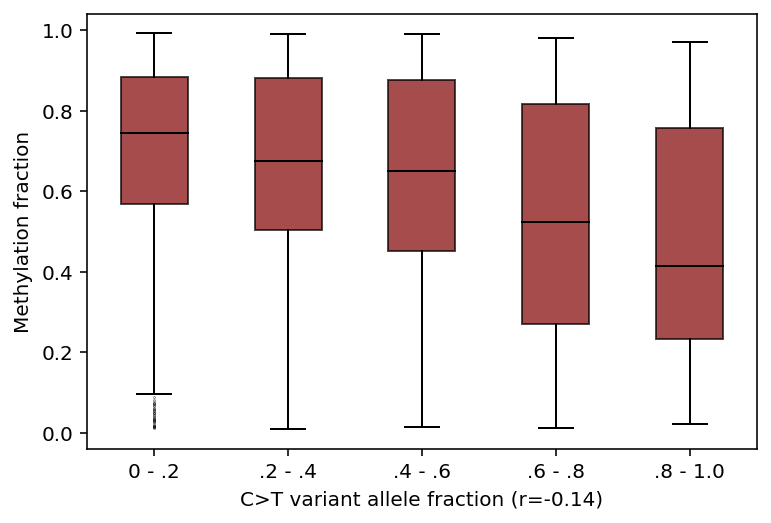

In [265]:
fig, axes = plt.subplots()
boxes = [ct_mut_in_measured_cpg_w_methyl_df[(ct_mut_in_measured_cpg_w_methyl_df['DNA_VAF'] < i + .2) & (ct_mut_in_measured_cpg_w_methyl_df['DNA_VAF'] >= i)]['methyl_fraction'] for i in np.arange(0,1,.2)]
bp = axes.boxplot(boxes, flierprops=dict(markersize=.1), labels=["0 - .2", ".2 - .4",".4 - .6",".6 - .8",".8 - 1.0"], patch_artist=True, boxprops=dict(facecolor="maroon", alpha=0.7, ))
# change color of median
for median in bp['medians']: 
    median.set(color ='black', 
               linewidth = 1) 

correlation = round(np.corrcoef(ct_mut_in_measured_cpg_w_methyl_df['DNA_VAF'], ct_mut_in_measured_cpg_w_methyl_df['methyl_fraction'])[1][0],2)
axes.set_xlabel("C>T variant allele fraction (r={})".format(correlation))
axes.set_ylabel("Methylation fraction")

# Understand how the effect of a mutation on linked CpGs changes with 1) linear distance, 2) 3-d space distance, and 3) methylation space (correlation between CpG sites)

In [97]:
illumina_cpg_locs_one_sorted = illumina_cpg_locs_df[illumina_cpg_locs_df['chr']=='1'].sort_values(by='start')

In [125]:
# subset to those we have corr for
illumina_cpg_locs_one_sorted = illumina_cpg_locs_one_sorted[illumina_cpg_locs_one_sorted['#id'].isin(chrom_one_corr.columns)]

In [126]:
chrom_one_dists = utils.get_distances_one_chrom('1', illumina_cpg_locs_df, illumina_cpg_locs_one_sorted['#id'].iloc[:1000].to_list())

In [99]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

In [130]:
# put columns in same order and subset
chrom_one_corr_w_dist = chrom_one_corr.loc[chrom_one_dists.columns, chrom_one_dists.columns]

In [131]:
chrom_one_corr_upper = upper_tri_masking(chrom_one_corr_w_dist)
chrom_one_dist_upper = upper_tri_masking(chrom_one_dists)

In [143]:
chrom_one_corr_upper

,cg00002593,cg00034556,cg00040588,cg00078456,cg00082285,cg00086243,cg00086266,cg00111697,cg00113194,cg00145911,...,cg27430493,cg27440283,cg27534567,cg27541454,cg27541892,cg27543922,cg27582017,cg27582546,cg27631599,ch.1.24684R
cg00002593,1.000000,0.013236,0.167133,0.115939,0.166383,0.435331,0.037976,0.176548,0.051558,0.204497,...,0.174347,0.084503,0.024704,0.066124,0.012491,0.108066,0.043953,0.140034,0.116052,0.006999
cg00002593,1.000000,0.013236,0.167133,0.115939,0.166383,0.435331,0.037976,0.176548,0.051558,0.204497,...,0.174347,0.084503,0.024704,0.066124,0.012491,0.108066,0.043953,0.140034,0.116052,0.006999
cg00002593,1.000000,0.013236,0.167133,0.115939,0.166383,0.435331,0.037976,0.176548,0.051558,0.204497,...,0.174347,0.084503,0.024704,0.066124,0.012491,0.108066,0.043953,0.140034,0.116052,0.006999
cg00002593,1.000000,0.013236,0.167133,0.115939,0.166383,0.435331,0.037976,0.176548,0.051558,0.204497,...,0.174347,0.084503,0.024704,0.066124,0.012491,0.108066,0.043953,0.140034,0.116052,0.006999
cg00002593,1.000000,0.013236,0.167133,0.115939,0.166383,0.435331,0.037976,0.176548,0.051558,0.204497,...,0.174347,0.084503,0.024704,0.066124,0.012491,0.108066,0.043953,0.140034,0.116052,0.006999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27582017,0.043953,-0.014920,0.018426,0.038163,0.038637,0.022696,0.079842,-0.017186,0.011007,0.024348,...,0.026284,0.055191,-0.031192,0.020342,-0.006102,-0.004255,1.000000,0.031686,0.018153,0.150460
cg27582017,0.043953,-0.014920,0.018426,0.038163,0.038637,0.022696,0.079842,-0.017186,0.011007,0.024348,...,0.026284,0.055191,-0.031192,0.020342,-0.006102,-0.004255,1.000000,0.031686,0.018153,0.150460
cg27582546,0.140034,-0.072979,0.117892,0.507910,0.419250,0.323807,-0.030114,0.315534,0.070870,0.490831,...,-0.029802,-0.068177,-0.031312,0.382701,0.020577,0.078058,0.031686,1.000000,0.112334,0.049765
cg27582546,0.140034,-0.072979,0.117892,0.507910,0.419250,0.323807,-0.030114,0.315534,0.070870,0.490831,...,-0.029802,-0.068177,-0.031312,0.382701,0.020577,0.078058,0.031686,1.000000,0.112334,0.049765


In [134]:
len(chrom_one_corr_upper[:1000])

1000

In [142]:
np.abs(chrom_one_dist_upper[:10000])

,cg00002593,cg00034556,cg00040588,cg00078456,cg00082285,cg00086243,cg00086266,cg00111697,cg00113194,cg00145911,...,cg27430493,cg27440283,cg27534567,cg27541454,cg27541892,cg27543922,cg27582017,cg27582546,cg27631599,ch.1.24684R
11658,0,702062,21919,295629,171523,126388,25898,456033,383924,400855,...,332702,26036,700257,293242,303008,36915,211110,206556,159973,78767
11658,0,702062,21919,295629,171523,126388,25898,456033,383924,400855,...,332702,26036,700257,293242,303008,36915,211110,206556,159973,78767
11658,0,702062,21919,295629,171523,126388,25898,456033,383924,400855,...,332702,26036,700257,293242,303008,36915,211110,206556,159973,78767
11658,0,702062,21919,295629,171523,126388,25898,456033,383924,400855,...,332702,26036,700257,293242,303008,36915,211110,206556,159973,78767
11658,0,702062,21919,295629,171523,126388,25898,456033,383924,400855,...,332702,26036,700257,293242,303008,36915,211110,206556,159973,78767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12116,256659,958721,234740,38970,428182,383047,282557,712692,640583,657514,...,589361,282695,956916,549901,46349,293574,467769,463215,416632,335426
12116,256659,958721,234740,38970,428182,383047,282557,712692,640583,657514,...,589361,282695,956916,549901,46349,293574,467769,463215,416632,335426
12116,256659,958721,234740,38970,428182,383047,282557,712692,640583,657514,...,589361,282695,956916,549901,46349,293574,467769,463215,416632,335426
12116,256659,958721,234740,38970,428182,383047,282557,712692,640583,657514,...,589361,282695,956916,549901,46349,293574,467769,463215,416632,335426


Text(0, 0.5, 'Unsigned correlation')

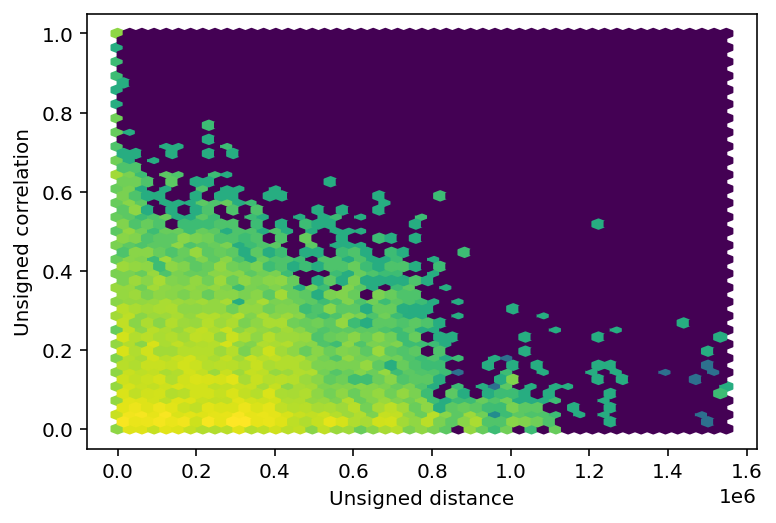

In [140]:
plt.hexbin(np.abs(chrom_one_dist_upper[:10000]), np.abs(chrom_one_corr_upper[:10000]), bins='log', gridsize=50)
plt.xlabel("Unsigned distance")
plt.ylabel("Unsigned correlation")

In [70]:
corrz = np.abs(chrom_one_df.reset_index(drop=True)).corrwith(chrom_one_corr[chrom_one_df.columns].iloc[:1000, :1000].reset_index(drop=True))

In [72]:
corrz.mean()

-0.0013603992131328618

In [75]:
np.log(np.abs(chrom_one_df))

,cg00000957,cg00001446,cg00008036,cg00008971,cg00011513,cg00014168,cg00019151,cg00020720,cg00034416,cg00036110,...,cg27442164,cg27497900,cg27511208,cg27530704,cg27543040,cg27573570,cg27584146,ch.1.1392349R,ch.1.2740682R,ch.1.175985039R
11650,-inf,17.450298,18.973271,17.505132,18.802858,13.261473,18.936690,18.185404,18.821746,17.348011,...,18.815199,18.854895,17.126030,16.876156,19.303892,16.928385,17.520821,17.486389,18.529424,18.961732
11653,17.450298,-inf,18.727290,14.574391,18.503673,17.435018,18.680265,17.532526,18.529066,15.119613,...,18.520284,18.573240,16.166355,16.622046,19.133492,16.550411,14.833951,14.146685,18.114072,18.712510
11683,18.973271,18.727290,-inf,18.711447,17.119746,18.969959,15.646802,18.366643,17.011460,18.754044,...,17.050568,16.780780,18.801686,18.842239,18.036350,18.834704,18.706703,18.716989,17.947267,14.505490
11688,17.505132,14.574391,18.711447,-inf,18.483819,17.490673,18.663652,17.479215,18.509715,15.576856,...,18.500760,18.554733,16.351610,16.743411,19.122965,16.680227,13.358210,13.518829,18.084619,18.696428
11696,18.802858,18.503673,17.119746,18.483819,-inf,18.798929,16.859355,18.027814,14.843106,18.537020,...,14.414273,15.873189,18.595875,18.645469,18.372733,18.636288,18.477859,18.490773,17.372558,17.043704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58122,16.928385,16.550411,18.834704,16.680227,18.636288,16.902498,18.792571,17.850629,18.658562,16.277133,...,18.650851,18.697474,15.407552,13.950277,19.206315,-inf,16.715672,16.636937,18.304170,18.821439
58164,17.520821,14.833951,18.706703,13.358210,18.477859,17.506589,18.658675,17.462853,18.503907,15.680095,...,18.494900,18.549182,16.400512,16.776721,19.119824,16.715672,-inf,14.134888,18.075722,18.691612
58290,17.486389,14.146685,18.716989,13.518829,18.490773,17.471654,18.669465,17.498091,18.516492,15.440228,...,18.507598,18.561212,16.290959,16.702826,19.126641,16.636937,14.134888,-inf,18.094967,18.702054
58357,18.529424,18.114072,17.947267,18.084619,17.372558,18.524256,17.841671,17.295284,17.449244,18.162922,...,17.423164,17.574087,18.247377,18.316944,18.685947,18.304170,18.075722,18.094967,-inf,17.914736


In [69]:
chrom_one_corr[chrom_one_df.columns].iloc[:1000, :1000]

cpg_name,cg00000957,cg00001446,cg00008036,cg00008971,cg00011513,cg00014168,cg00019151,cg00020720,cg00034416,cg00036110,...,cg27442164,cg27497900,cg27511208,cg27530704,cg27543040,cg27573570,cg27584146,ch.1.1392349R,ch.1.2740682R,ch.1.175985039R
cpg_name,,,,,,,,,,,,,,,,,,,,,
cg04244851,0.240866,0.308588,0.097450,0.250409,0.103316,0.190107,0.223032,0.046432,-0.017962,0.503106,...,0.429947,0.074571,0.042198,0.096592,-0.005623,0.230825,0.367909,0.051441,0.210997,0.108752
cg26361540,-0.036996,0.037169,0.063890,0.119250,-0.021226,0.027172,-0.014350,0.469811,0.193341,0.039319,...,0.085756,0.271737,0.055323,-0.030352,0.066272,0.083016,0.057504,0.307601,0.221828,0.469830
cg04079251,0.270621,0.245014,0.108292,0.024026,0.180322,0.056773,0.187474,-0.056705,-0.093877,0.206807,...,0.159894,-0.013036,0.023984,0.208456,0.121278,0.181286,0.107990,0.046556,0.099414,-0.016790
cg04129132,0.330785,0.271567,0.070595,0.135860,0.266308,0.168188,0.231501,-0.126631,-0.150301,0.234872,...,0.226423,-0.052542,-0.000166,0.248342,0.064551,0.129509,0.115707,-0.068777,-0.029213,-0.103988
cg11461030,0.094619,0.073659,0.263033,0.032079,0.025188,0.155465,0.020307,0.146051,0.021649,0.166391,...,0.111564,0.110779,0.334055,0.059542,0.096307,0.150463,0.141183,0.081755,0.116469,0.082651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg07066868,-0.088380,-0.006446,0.072087,0.018317,-0.055440,-0.032360,0.155554,0.501310,0.223278,-0.023847,...,0.022082,0.305830,0.011651,-0.074990,0.040157,0.087991,0.042180,0.263423,0.251480,0.314747
cg24878454,-0.007092,0.017952,0.108692,0.023735,-0.057553,0.054761,0.043754,0.233094,0.070421,0.095689,...,0.078137,0.156713,0.206720,0.002554,0.010872,0.093567,0.106407,0.161284,0.132126,0.188719
cg26246897,0.139633,0.154932,0.202043,0.156223,0.068888,0.152293,0.079305,0.067276,-0.022311,0.436375,...,0.310248,0.045984,0.081019,0.061950,0.027443,0.169028,0.216785,0.063549,0.236612,0.064914
